In [1]:
from psgd.sampling import SimpleSampler
from psgd.grouping import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from craynn.utils import mnist

from tqdm import tqdm_notebook

## Data

In [3]:
X_train, _, X_test, _ = mnist(cast='float32')

In [4]:
X_train /= 255.0
X_test /= 255.0

In [5]:
def get_rotated(X):
    indx = np.random.permutation(X.shape[0])
    n = X.shape[0]

    X_rot = X[indx[(n // 2):]]
    X_original = X[indx[:(n // 2)]]
    
    def rotate_data(X, angles):
        from skimage.transform import rotate

        if not hasattr(angles, 'shape'):
            angles = np.ones(X.shape[0]) * angles
        return np.array([
            rotate(X[i, 0], angle=angles[i], order=3, resize=False, preserve_range=True).reshape(1, 28, 28)
            for i in tqdm_notebook(range(X.shape[0]))
        ]).astype('float32')
    

    angles = np.random.normal(-0.1, 1, size=X_rot.shape[0])
    X_rot = rotate_data(X_rot, angles)

    angles = np.random.normal(0.1, 1, size=X_original.shape[0])
    X_original = rotate_data(X_original, angles = angles)
    
    X = np.vstack([X_original, X_rot])
    y = np.hstack([
        np.ones(X_original.shape[0], dtype='float32'),
        np.zeros(X_rot.shape[0], dtype='float32')
    ])
    
    indx = np.random.permutation(X.shape[0])
    return X[indx], y[indx]

In [6]:
X_train, y_train = get_rotated(X_train)
X_test, y_test = get_rotated(X_test)

HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

In [7]:
X_train.shape

(60000, 1, 28, 28)

In [8]:
import theano
import theano.tensor as T

In [9]:
X = T.fmatrix()
w = T.fmatrix()

project = theano.function([X, w], X.dot(w.T))

In [10]:
X_train.shape[0] // np.prod((60, 5, 5, 4, 4))

2

In [11]:
%%time

indx_tree = lsh_random_tree(
    X_train.reshape(-1, 28 * 28),
    project,
    split_seq=(60, 5, 5, 4, 4)
)

CPU times: user 3.53 s, sys: 163 ms, total: 3.69 s
Wall time: 1.05 s


In [12]:
%%time

indx_ptree = lsh_random_points_tree(
    X_train.reshape(-1, 28 * 28),
    project,
    split_seq=(60, 5, 5, 4, 4)
)

CPU times: user 2.47 s, sys: 143 ms, total: 2.62 s
Wall time: 708 ms


In [13]:
%%time

indx_grid = lsh_random_grid(
    X_train.reshape(-1, 28 * 28),
    project,
    split_seq=(60, 5, 5, 4, 4)
)

CPU times: user 268 ms, sys: 18.5 ms, total: 286 ms
Wall time: 76.8 ms


In [14]:
%%time

indx_pgrid = lsh_random_point_grid(
    X_train.reshape(-1, 28 * 28),
    project,
    split_seq=(60, 5, 5, 4, 4)
)

CPU times: user 258 ms, sys: 7.77 ms, total: 265 ms
Wall time: 75.4 ms


In [15]:
indx_tree = np.array(indx_tree)
indx_ptree = np.array(indx_ptree)
indx_grid = np.array(indx_grid)
indx_pgrid = np.array(indx_pgrid)

In [16]:
def plot(indx, n_plot=10):
    n_plot = 10
    nrows=indx.shape[1]

    plt.subplots(nrows=nrows, ncols=n_plot, figsize=(n_plot * 2, nrows * 2))

    for i in range(n_plot):
        for j in range(nrows):
            plt.subplot(nrows, n_plot, i + j * n_plot + 1)
            k = indx[i, j]
            plt.imshow(X_train[k, 0], cmap=plt.cm.Greys_r)
    plt.plot()

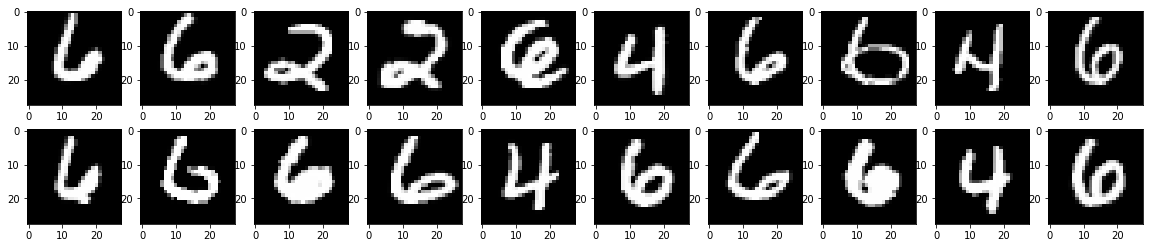

In [17]:
plot(indx_tree)

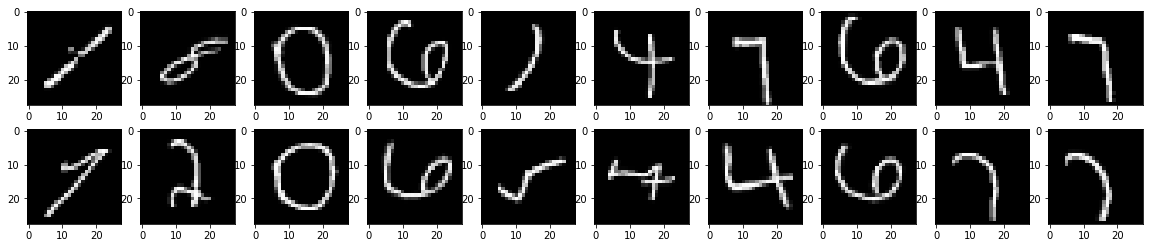

In [18]:
plot(indx_ptree)

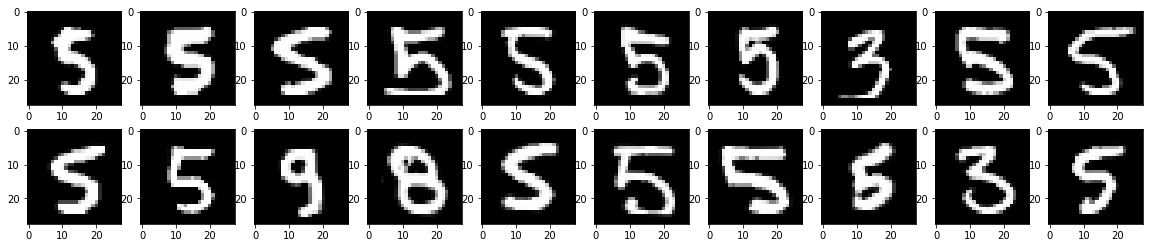

In [19]:
plot(indx_grid)

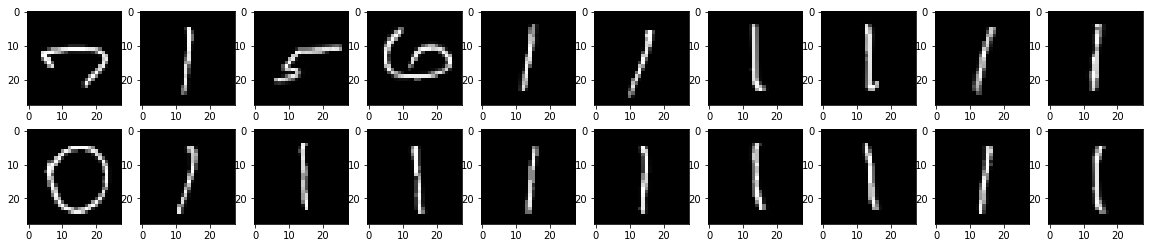

In [20]:
plot(indx_pgrid)

In [21]:
def get_distance(indx_pairs=None):
    if indx_pairs is None:
        indx_pairs = np.random.permutation(X_train.shape[0]).reshape(-1, 2)

    distance = []

    for i in range(indx_pairs.shape[0]):
        x1 = X_train[indx_pairs[i, 0]]
        x2 = X_train[indx_pairs[i, 1]]
        distance.append(np.sum((x1 - x2) ** 2))
    
    return distance

In [22]:
distance_random = get_distance()
distance_tree = get_distance(indx_tree)
distance_ptree = get_distance(indx_ptree)
distance_grid = get_distance(indx_grid)
distance_pgrid = get_distance(indx_pgrid)

### L2 distance seems to be a quite weak similarity metric for rotated images

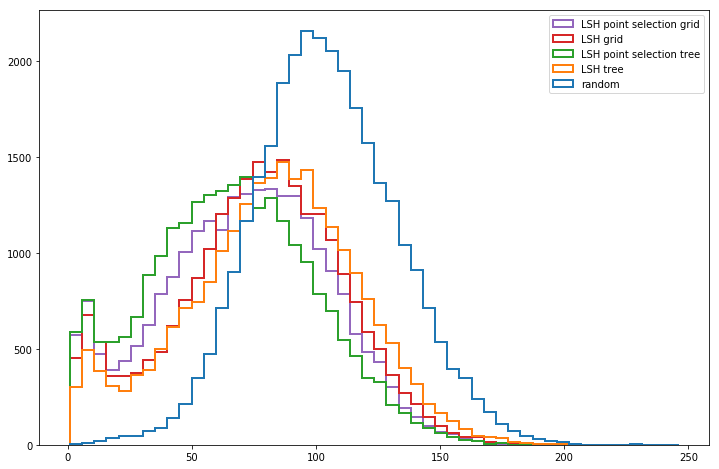

In [23]:
plt.figure(figsize=(12, 8))

_ = plt.hist([
    distance_random,
    distance_tree,
    distance_ptree,
    distance_grid,
    distance_pgrid
],
    bins=50, histtype='step', lw=2,
    label=['random', 'LSH tree', 'LSH point selection tree', 'LSH grid', 'LSH point selection grid']
)

plt.legend()

## Tree vs grid

In [24]:
rpoints = [1, 2, 4, 8, 16]

In [25]:
%%time

indx_pgrid = [
    np.array(lsh_random_point_grid(
        X_train.reshape(-1, 28 * 28),
        project,
        split_seq=(60, 5, 5, 4, 4),
        num_random_points=i
    ))
    for i in rpoints
]

CPU times: user 2.55 s, sys: 19.1 ms, total: 2.57 s
Wall time: 825 ms


In [26]:
distances_pgrid =[
    get_distance(indx)
    for indx in indx_pgrid
]

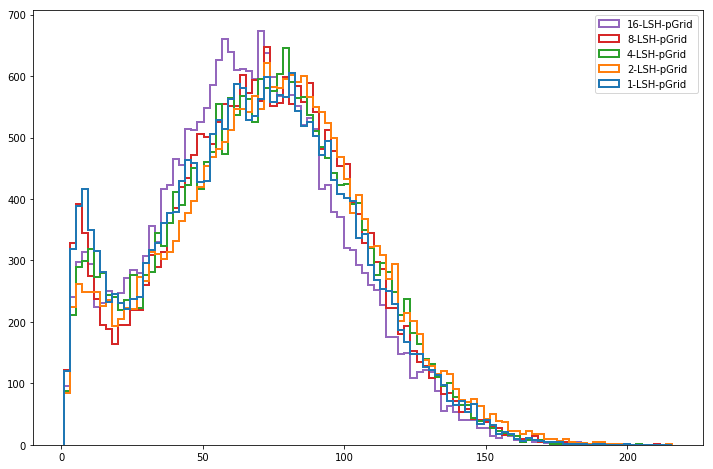

In [27]:
plt.figure(figsize=(12, 8))

_ = plt.hist(
    distances_pgrid,
    bins=100, histtype='step', lw=2,
    label=[ '%d-LSH-pGrid' % i for i in rpoints ]
)

plt.legend()

In [28]:
%%time

indx_ptree = [
    np.array(lsh_random_points_tree(
        X_train.reshape(-1, 28 * 28),
        project,
        split_seq=(60, 5, 5, 4, 4),
        num_random_points=i
    ))
    for i in rpoints
]

CPU times: user 11.8 s, sys: 273 ms, total: 12.1 s
Wall time: 3.18 s


In [29]:
distances_ptree =[
    get_distance(indx)
    for indx in indx_ptree
]

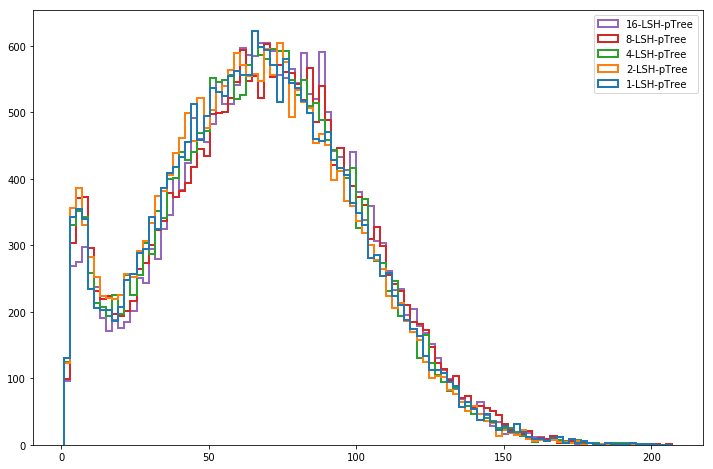

In [34]:
plt.figure(figsize=(12, 8))

_ = plt.hist(
    distances_ptree,
    bins=100, histtype='step', lw=2,
    label=[ '%d-LSH-pTree' % i for i in rpoints ]
)

plt.legend()

## Conclusion

- LSH hashing is better than random;
- LSH random point selection heuristic is slightly better than random direction;
- LSH grid is around 10x faster than equalent tree methods, while having approximately the same results;
- all of LSH methods are much faster than any neighbors based heuristics (see, for example, `psgd.grouping.greedy`) (which are not tested as they need the whole day to run).

Complexity of LSH tree or grid:
$$O(N D \log^2 N),$$

where:
- $N$ - number of points;
- $D$ - dimensionality.

The main hypothesis that LSH grouping will do a great job applied to intermediate features.